## Brillouin-Wigner correction of the quasiparticle Hamiltonian

We approach and analyze the structure of the corrections and the properties of these effective Hamiltonians using both the nn-pp quasiparticle and the nn-pp/ np quasiparticle frameworks.

### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp framework

#### Imports

In [2]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [3]:
file_name='data/usdb.nat' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Set the specific nucleus

In [176]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=8
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{24}$Mg'



Compute the NSM Hamiltonian

In [177]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=1)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:12<00:00, 1324.05it/s]


✅ Two-body operator built: shape=(28503, 28503), nnz=6030191
[-132.37718673]
(28503, 28503)


#### Get the Quasiparticle basis and compute the operators

In [196]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(225, 12)
(28278, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [197]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


#### Create a probability distribution over the diagonal values of $H_{RR}$

Since we want to reconstruct randomly the mean field component of $H_{RR}$ that contributes to the magnitude of each virtual process in the two-body truncation. We sample the values using the distribution generated by the mean field Hamiltonian. For large system size this can be esily performed using a Monte Carlo algorithm, like Metropolis Hasting.

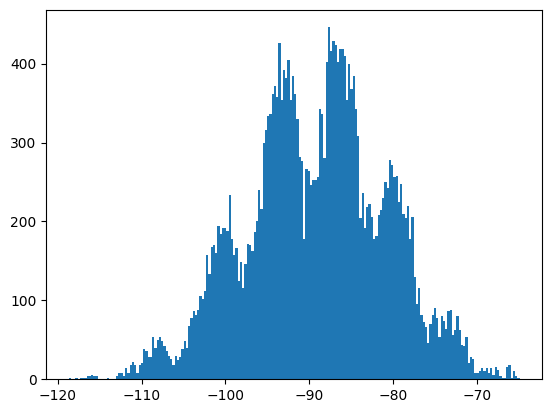

[  2   0   0   2   0   2   2   2   4   4   6   4   4   0   0   0   0   2
   0   0   0   4   8   8   4  14   8  18  22  18   8  18  20  38  36  28
  28  54  40  50  54  48  42  36  30  26  18  30  24  28  38  48  40  68
  78  86  82  88 106 102 112 158 134 168 170 160 194 184 192 192 188 234
 178 158 166 124 148 116 146 172 170 162 186 200 240 216 300 316 334 336
 362 372 358 426 354 392 382 404 354 384 362 330 282 276 178 266 264 246
 252 252 256 342 336 280 402 446 416 428 424 402 418 418 410 354 400 368
 384 342 308 204 236 192 218 222 206 178 182 208 214 230 250 242 278 272
 256 258 224 248 210 204 220 178 206 130  96 116  82  72  66  46  70  82
  90  78  54  80  74  64  86  88  56  62  80  62  44  42  54  20  28  26
   8   8  10  14  10  14   8  14   6  16  12   4   2   2  16  18   2  10
   4   2]
[-118.68336994 -118.41473568 -118.14610142 -117.87746716 -117.60883291
 -117.34019865 -117.07156439 -116.80293013 -116.53429587 -116.26566161
 -115.99702735 -115.7283931  -115.45975884 -1

In [198]:
bins=200
_=plt.hist(hamiltonian_rr.diagonal(),bins=bins)
plt.show()

hist_diag_hamiltonian_rr,range_energies_rr=np.histogram(hamiltonian_rr.diagonal(),bins=bins)
print(hist_diag_hamiltonian_rr)
print(range_energies_rr)
probability_distribution_diag_hamiltonian_rr=hist_diag_hamiltonian_rr/np.sum(hist_diag_hamiltonian_rr)

#### Investigate the magnitude of $H_{QR}$

In [181]:
for q_index in range(2):
    for r_index in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,r_index]!=0:
            print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr[q_index,r_index])
            idx_q=np.nonzero(QPC.quasiparticle_basis[q_index])[0]
            indices=[]
            quasiparticle_element_in_full_basis=np.zeros_like(QPC.rest_basis[r_index])
            for qi0 in idx_q:
                indices.append(QPC.couples[qi0][0])
                indices.append(QPC.couples[qi0][1])
            print(indices)
            quasiparticle_element_in_full_basis[indices]=1
            print(np.sum(np.abs(quasiparticle_element_in_full_basis-QPC.rest_basis[r_index])))
            print('\n')

q_index= 0  r_index= 25  value= 1.04372120112434
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 35  value= 0.44278468996383347
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 63  value= 0.3580252065068405
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 66  value= 0.14158688862318322
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 72  value= -1.2129704215656376
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 90  value= 0.45225308401658476
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 231  value= -0.26685623313589846
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 234  value= -1.0895624212056287
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 240  value= -0.028530166040710125
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15, 18, 19]
4


q_index= 0  r_index= 258  value= -0.6322793396075583
[0, 5, 1, 4, 12, 17, 13, 16, 14, 15,

Plot the Quasiparticle Hamiltonian

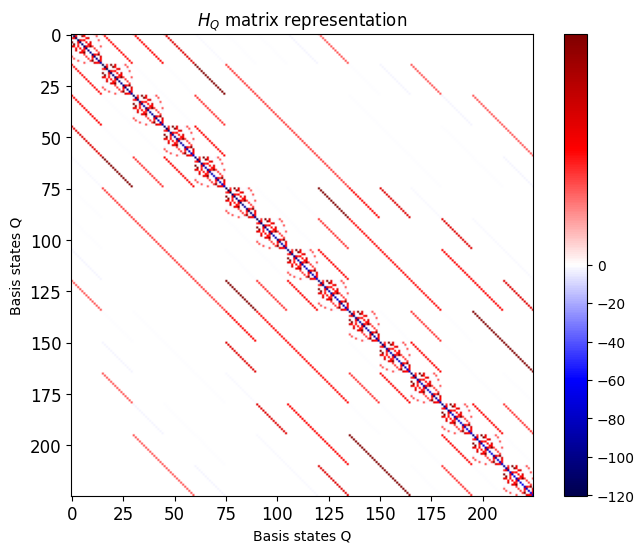

In [182]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [10]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11]]


### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp/np framework

#### Imports

In [183]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverter


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [12]:
file_name='data/cki' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:00<00:00, 14.12it/s]


Set the specific nucleus

In [39]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{10}$Be'



Compute the NSM Hamiltonian

In [40]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=3)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:00<00:00, 16552.78it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-39.4534158  -35.74941099 -34.02402475]
(51, 51)


Plot the NSM Hamiltonian

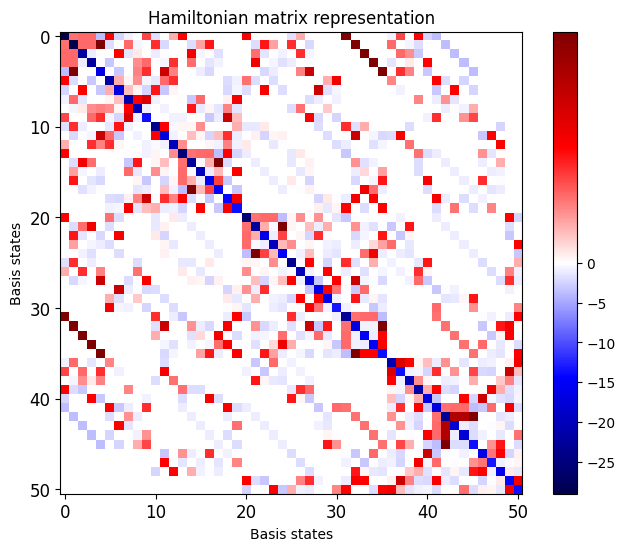

In [41]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In [151]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverter()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(330, 24)
(3876, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [152]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


Plot the Quasiparticle Hamiltonian

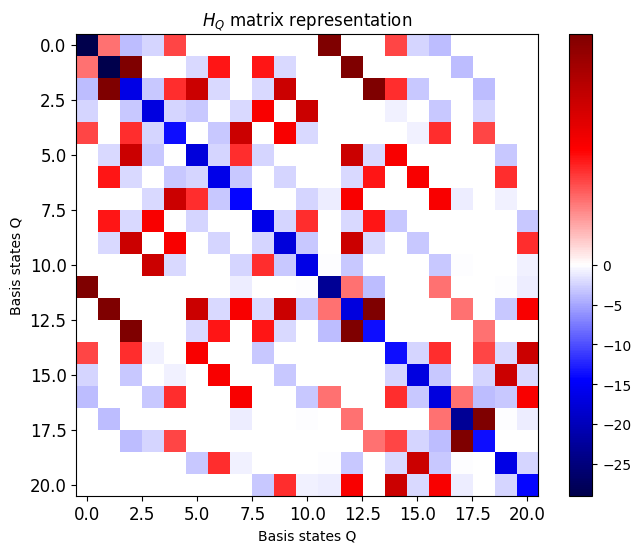

In [44]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [45]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11], [0, 9], [1, 8], [2, 7], [3, 6], [4, 11], [5, 10]]


In [46]:
count=0
for key in twobody_matrix.keys():
    a,b,c,d=key
    
    if [min(a,b),max(a,b)] in QPC.couples or [min(c,d),max(c,d)] in QPC.couples:
        continue
    else:
        count+=1
        
print(f'Number of non quasiaparticle two-body matrix elements: {count/len(twobody_matrix)}')

Number of non quasiaparticle two-body matrix elements: 0.6685393258426966


### Exact Brillouin-Wigner method

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [183]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        #diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        #single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_full_brillouinwigner_method=[]
interaction_terms_full_brillouinwigner_method=[]
infidelities_full_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_full_brillouinwigner_method.append(1-fidelity)
    history_errors_full_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
    

100%|██████████| 20/20 [00:00<00:00, 160.63it/s]

-130.99045473437553
0.0104756116570635 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

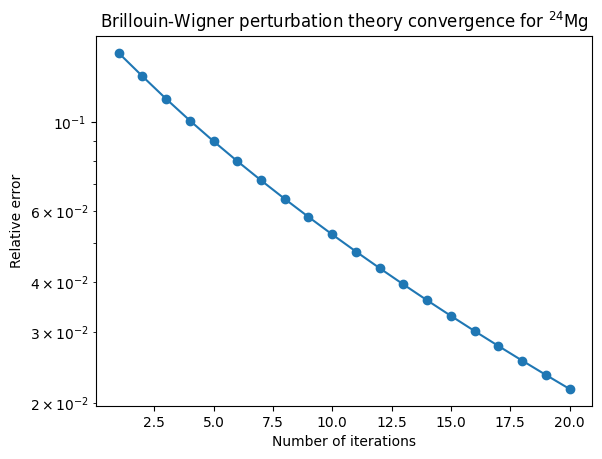

In [796]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.show()

##### Fit of the curve

Model results (lower SSE and higher R2 are better):

power (logreg):
  params: (np.float64(0.2293627943520836), np.float64(0.6983969594285804))
  SSE=7.840e-03, R2=0.7099

exp:
  params: [0.15998423 0.10913594]
  stderr: [0.00209289 0.00209109]
  SSE=1.279e-04, R2=0.9953

stretched_exp:
  params: [0.18181933 0.13000842 0.80367417]
  stderr: [0.0011786  0.0012738  0.00749586]
  SSE=3.321e-06, R2=0.9999

power*exp:
  params: [0.16461412 0.09573231 0.0904938 ]
  stderr: [0.00092141 0.0091801  0.00192603]
  SSE=1.777e-05, R2=0.9993


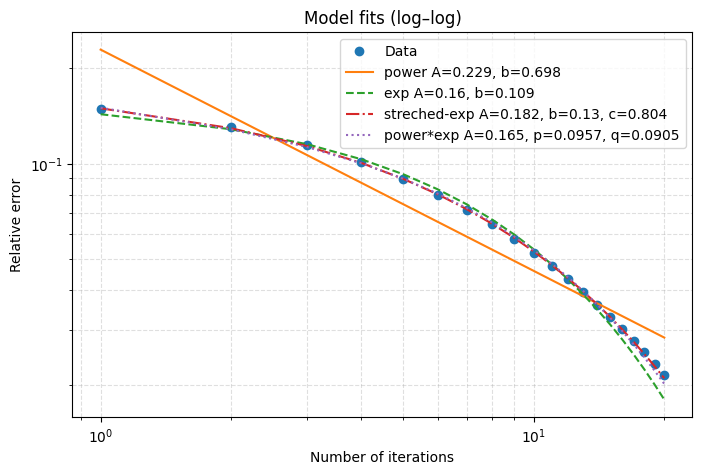

Best breakpoint (simple split) at k=5 (1-based iteration 5), total SSE=2.030e-04


In [797]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# --- data: replace with your variables ---
x = np.arange(1, nsteps_iteration + 1)
y = np.array(history_errors_full_brillouinwigner_method)

# avoid zeros or negative y when taking logs
eps = 1e-300
y = np.clip(y, eps, None)

# --- model definitions ---
def power_model(x, A, b):
    return A * x**(-b)

def exp_model(x, A, b):
    return A * np.exp(-b * x)

def stretched_exp(x, A, b, c):
    # A * exp( - (b*x)^c )
    return A * np.exp(- (b * x)**c)

def power_times_exp(x, A, p, q):
    # A * x^{-p} * exp(-q * x)
    return A * x**(-p) * np.exp(-q * x)

# --- fitting helper that wraps curve_fit with bounds and initial guesses ---
def fit_curve(model, xdata, ydata, p0=None, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(model, xdata, ydata, p0=p0, bounds=bounds, maxfev=100000)
        residuals = ydata - model(xdata, *popt)
        sse = np.sum(residuals**2)
        # R^2 on y (not on log) as a simple metric
        ss_tot = np.sum((ydata - np.mean(ydata))**2)
        r2 = 1 - sse / ss_tot if ss_tot > 0 else np.nan
        return popt, np.sqrt(np.diag(pcov)), sse, r2
    except Exception as e:
        print("Fit failed for", model.__name__, ":", e)
        return None, None, np.inf, np.nan

# --- Fit models ---
results = {}

# 1) Power law: fit by linear regression on log-log (more stable)
X = np.log(x)
Y = np.log(y)
slope, intercept, rval, pval, stderr = linregress(X, Y)
b_power = -slope
A_power = np.exp(intercept)
# compute sse/r2 for consistency with other fits
y_power_pred = power_model(x, A_power, b_power)
sse_power = np.sum((y - y_power_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_power = 1 - sse_power / ss_tot
results['power (logreg)'] = ((A_power, b_power), None, sse_power, r2_power)

# 2) Exponential (nonlinear fit)
p0 = [y[0], 0.5]  # initial A and b
popt, perr, sse, r2 = fit_curve(exp_model, x, y, p0=p0, bounds=([0,0],[np.inf,np.inf]))
results['exp'] = (popt, perr, sse, r2)

# 3) Stretched exponential
# sensible initial guesses: A ~ y0, b ~ 0.5/x_mean, c ~ 1
p0 = [y[0], 0.1, 0.0]
bounds = ([0, 0, 0], [np.inf, np.inf, 5])  # restrict c to positive
popt_se, perr_se, sse_se, r2_se = fit_curve(stretched_exp, x, y, p0=p0, bounds=bounds)
results['stretched_exp'] = (popt_se, perr_se, sse_se, r2_se)

# 4) power * exponential
p0 = [y[0], 0.5, 0.1]
bounds = ([0, 0, 0], [np.inf, 5, np.inf])
popt_pe, perr_pe, sse_pe, r2_pe = fit_curve(power_times_exp, x, y, p0=p0, bounds=bounds)
results['power*exp'] = (popt_pe, perr_pe, sse_pe, r2_pe)

# --- Print results ---
print("Model results (lower SSE and higher R2 are better):")
for name, (popt, perr, sse, r2) in results.items():
    print(f"\n{name}:")
    if popt is None:
        print("  fit failed")
    else:
        print("  params:", popt)
        if perr is not None:
            print("  stderr:", perr)
        print(f"  SSE={sse:.3e}, R2={r2:.4f}")

# --- Plot data and model fits ---
plt.figure(figsize=(8,5))
plt.loglog(x, y, 'o', label='Data')

# Power-law (from logreg)
plt.loglog(x, y_power_pred, '-', label=f'power A={A_power:.3g}, b={b_power:.3g}')

# Exponential (if fit succeeded)
if results['exp'][0] is not None:
    Aexp, bexp = results['exp'][0]
    plt.loglog(x, exp_model(x, Aexp, bexp), '--', label=f'exp A={Aexp:.3g}, b={bexp:.3g}')

# Stretched exponential
if results['stretched_exp'][0] is not None:
    Ase, bse, cse = results['stretched_exp'][0]
    plt.loglog(x, stretched_exp(x, Ase, bse, cse), '-.', label=f'streched-exp A={Ase:.3g}, b={bse:.3g}, c={cse:.3g}')

# power * exp
if results['power*exp'][0] is not None:
    Ape, ppe, qpe = results['power*exp'][0]
    plt.loglog(x, power_times_exp(x, Ape, ppe, qpe), ':', label=f'power*exp A={Ape:.3g}, p={ppe:.3g}, q={qpe:.3g}')

plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title('Model fits (log–log)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# --- Optional: check for a breakpoint (simple brute-force) ---
# Try splitting the data at every candidate k and fit power-laws to left/right segments,
# pick k that minimizes total SSE.
xmin_seg = 3  # minimum points in a segment
best_k, best_sse = None, np.inf
for k in range(xmin_seg, len(x)-xmin_seg):
    # fit left (log-linear)
    xl, yl = x[:k], y[:k]
    Xl, Yl = np.log(xl), np.log(yl)
    slope_l, intercept_l, *_ = linregress(Xl, Yl)
    Al, bl = np.exp(intercept_l), -slope_l
    pred_l = power_model(xl, Al, bl)
    sse_l = np.sum((yl - pred_l)**2)
    # fit right
    xr, yr = x[k:], y[k:]
    Xr, Yr = np.log(xr), np.log(yr)
    slope_r, intercept_r, *_ = linregress(Xr, Yr)
    Ar, br = np.exp(intercept_r), -slope_r
    pred_r = power_model(xr, Ar, br)
    sse_r = np.sum((yr - pred_r)**2)
    if sse_l + sse_r < best_sse:
        best_sse = sse_l + sse_r
        best_k = k

print(f"Best breakpoint (simple split) at k={best_k} (1-based iteration {best_k}), total SSE={best_sse:.3e}")


##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

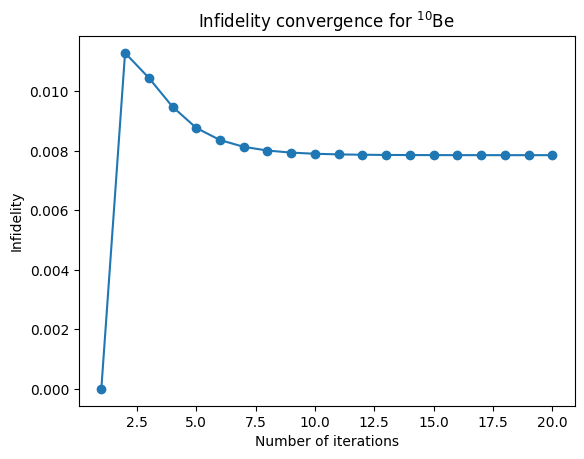

In [11]:
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [18]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_full_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.68529103]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_full_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [ ]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b)
            count_3+=1
        if np.abs(base_a-base_b).sum()==8 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_4+=1
print(count_0,count_1//2,count_2//2,count_3//2,count_4//2)

### Brillouin-Wigner method with mean field approximation of $H_{RR}$

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [184]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations_meanfield=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations_meanfield.append(update)  # Store result
    
history_errors_meanfield_brillouinwigner_method=[]
interaction_terms_meanfield_brillouinwigner_method=[]
infidelities_meanfield_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_meanfield[j]/e**(j+1)
    interaction_terms_meanfield_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 256.52it/s]

-129.88383074002164
0.018835239336493868 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

NameError: name 'history_errors_full_brillouinwigner_method' is not defined

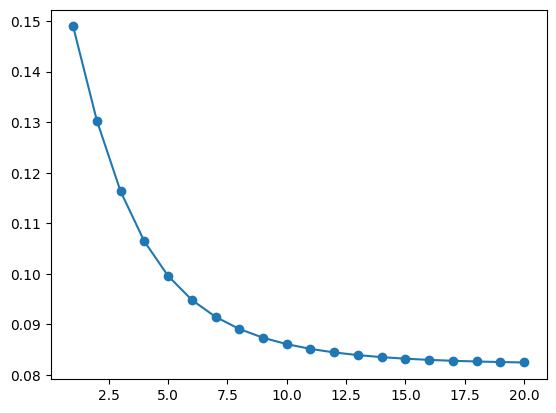

In [21]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')

plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

NameError: name 'infidelities_full_brillouinwigner_method' is not defined

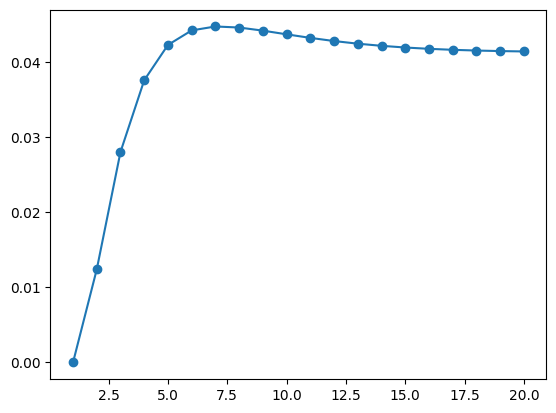

In [22]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [24]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_meanfield_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [24]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_meanfield_brillouinwigner_method[-1][a,b])
            count_3+=1
        if np.abs(base_a-base_b).sum()==8 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_meanfield_brillouinwigner_method[-1][a,b])
            count_4+=1
print(count_0,count_1//2,count_2//2,count_3//2,count_4//2)

225 1800 7048 0 0


### Brillouin-Wigner method with mean field UNIFORM approximation of $H_{RR}$

#### Initialize the uniform mean field $H_{RR}$ matrix

In [18]:
from scipy.sparse import lil_matrix,identity
hamiltonian_mfhf=np.average(hamiltonian_rr.diagonal())*identity(QPC.rest_basis.shape[0])


    

Now, let's try to compute the correction using this effective diagonal Hamiltonian and lets see what Happens.

In [19]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_mfhf
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_meanfield_uniform_brillouinwigner_method=[]
interaction_terms_meanfield_uniform_brillouinwigner_method=[]
infidelities_meanfield_uniform_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_meanfield_uniform_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_uniform_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_uniform_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 181.45it/s]

-82.81898591992571
0.10731549836038697 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

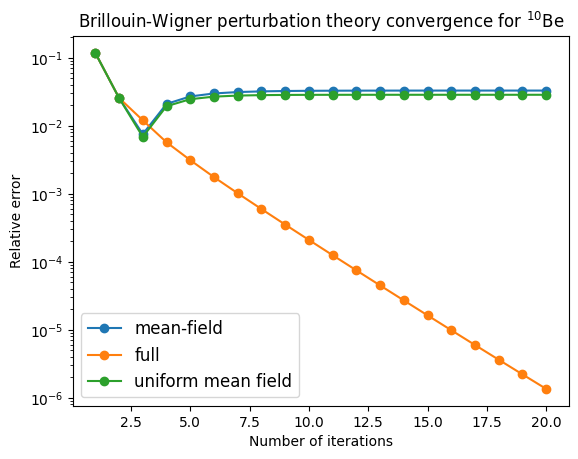

In [19]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

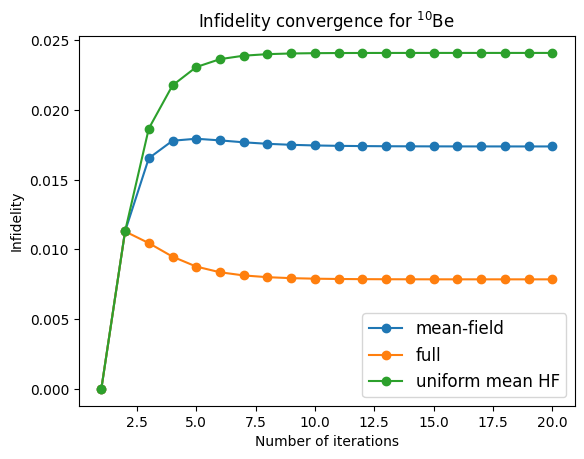

In [20]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean HF')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [20]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


Let's look at the structure of the Quasiparticle Hamiltonian

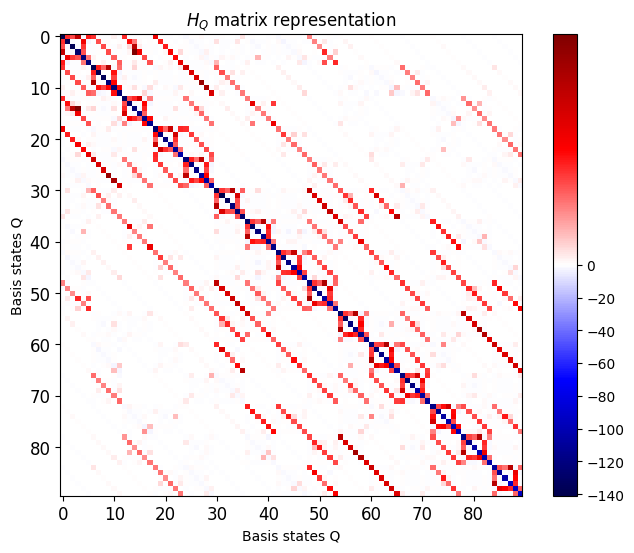

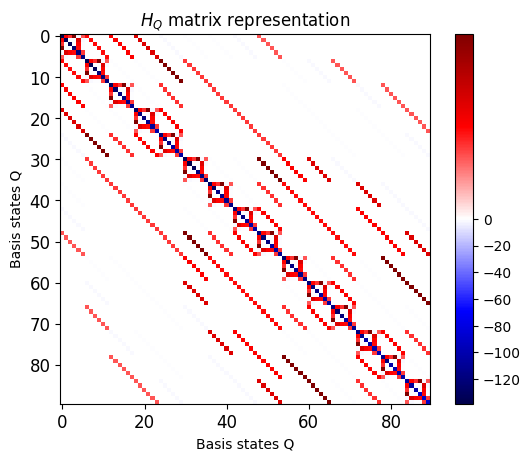

In [21]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()+ interaction_terms_meanfield_uniform_brillouinwigner_method[-1].toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

##### Plot the evolution of each element in the Hamiltonian

In [22]:
elements_vs_t=[]
index=[]
for a in range(hamiltonian_qq.shape[0]):
    for b in range(a,hamiltonian_qq.shape[0]):
        index.append([a,b])
        element=[]
        for t in range(nsteps_iteration):
            if t==0:
                element.append(hamiltonian_qq[a,b])
            else:
                element.append(hamiltonian_qq[a,b]+interaction_terms_meanfield_uniform_brillouinwigner_method[t][a,b])
        elements_vs_t.append(np.asarray(element))

elements_vs_t=np.asarray(elements_vs_t)                

In [ ]:
print(elements_vs_t.shape)
for i,a in enumerate(elements_vs_t):
    if np.abs(a[-1]-a[0])>0.1:
        print(index[i])
        plt.plot(np.arange(nsteps_iteration),a)
        plt.show()

### Using only 2-body quasiparticle connections in $H_{QR}$ for the Brillouin-Wigner Method

#### Imports

In [185]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [186]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [187]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 19795.53it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

In [188]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [189]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T



#### Investigate the magnitude of $H_{QR}$

We can check that the magnitude of the couplings of the $H_{QR}$ is similar to the $H_{QR}$ of a generic many-body hamiltonian. Maybe it's important to check the connectivity to figure out if more or less we can reduce it randomly or not.

In [190]:
count=0
for q_index in range(hamiltonian_qr_2b.shape[0]):
    for r_index in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,r_index]!=0:
            # print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr_2b[q_index,r_index])
            # print('\n')
            count+=1

print(count)

2555


In [165]:
print(hamiltonian_qr.shape,hamiltonian_qr_2b.shape)

(225, 28278) (36, 604)


In [191]:
print((1-2/12)*(1-2/12))
print((1-4/12)*(1-4/12))
print((1-4/12)*(1-4/12))



0.6944444444444445
0.44444444444444453
0.44444444444444453


In [192]:
for q_index in range(QPC.quasiparticle_basis.shape[0]):
    count=0
    for line in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,line]!=0:
            count+=1
    print(count)

    count2=0
    for line in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,line]!=0:
            count2+=1
    print(count2)
    
    print('ratio=',count2/count)





178
68
ratio= 0.38202247191011235
196
60
ratio= 0.30612244897959184
176
56
ratio= 0.3181818181818182
196
52
ratio= 0.2653061224489796
178
60
ratio= 0.33707865168539325
196
56
ratio= 0.2857142857142857
178
60
ratio= 0.33707865168539325
202
74
ratio= 0.36633663366336633
176
76
ratio= 0.4318181818181818
178
72
ratio= 0.4044943820224719
172
74
ratio= 0.43023255813953487
194
76
ratio= 0.3917525773195876
168
56
ratio= 0.3333333333333333
172
76
ratio= 0.4418604651162791
194
84
ratio= 0.4329896907216495
188
80
ratio= 0.425531914893617
192
76
ratio= 0.3958333333333333
186
84
ratio= 0.45161290322580644
192
52
ratio= 0.2708333333333333
188
72
ratio= 0.3829787234042553
192
80
ratio= 0.4166666666666667
188
71
ratio= 0.3776595744680851
210
72
ratio= 0.34285714285714286
186
80
ratio= 0.43010752688172044
188
60
ratio= 0.3191489361702128
180
74
ratio= 0.4111111111111111
172
76
ratio= 0.4418604651162791
176
72
ratio= 0.4090909090909091
180
74
ratio= 0.4111111111111111
172
76
ratio= 0.4418604651162791
18

IndexError: index (36) out of range

In [ ]:
print(hamiltonian_qr_2b)

#### Create the two-body corrections using the sampled reconstruction of the $H_{RR}$ mean field term and keeping the off diagonal transition of the two-body $H_{RR}$. 

In [199]:
print(range_energies_rr.shape,probability_distribution_diag_hamiltonian_rr.shape)
new_diagonal_contribution=np.random.choice(range_energies_rr[:-1],size=hamiltonian_rr_2b.shape[0],p=probability_distribution_diag_hamiltonian_rr)

#delta_energy_samples=np.max(hamiltonian_rr.diagonal())-hamiltonian_rr.diagonal()
#delta_energy_samples=hamiltonian_rr.diagonal()-np.min(hamiltonian_rr.diagonal())

#p_energy=delta_energy_samples/np.sum(delta_energy_samples)

#new_diagonal_contribution=np.random.choice(hamiltonian_rr.diagonal(),size=hamiltonian_rr_2b.shape[0],p=p_energy)

(201,) (200,)


In [200]:
from scipy.sparse import lil_matrix
#hamiltonian_rr_2body=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))


# in order to take into account of the extensive magnitude of the energy
for r in range(hamiltonian_rr_2b.shape[0]):
    #gamma=np.random.normal(0,np.std(hamiltonian_rr.diagonal()))
    hamiltonian_rr_2b[r,r]=new_diagonal_contribution[r]#(hamiltonian_rr_2b[r,r]-mean_2b_hamiltonian_rr)*(np.average(hamiltonian_rr.diagonal()))/(mean_2b_hamiltonian_rr)

    
    print(hamiltonian_rr_2b[r,r])
    print(hamiltonian_rr[r,r],'\n')

-91.01404130148813
-106.22944384920635 

-101.49077738809528
-101.20254408730167 

-81.34320799077383
-98.07438319444441 

-87.79043019791669
-109.11239057539684 

-83.22364780119051
-108.0196628968254 

-79.46276818035717
-106.16699182539682 

-87.2531616806548
-107.97626414682549 

-95.58082369821432
-101.26191583333329 

-95.04355518095241
-99.26916422619044 

-86.98452742202385
-100.6766113492063 

-80.80593947351193
-100.53653081349208 

-91.28267556011909
-96.25922438492066 

-88.05906445654765
-94.55793089285712 

-94.77492092232146
-99.56158722222216 

-69.79193486964289
-102.46556198412691 

-93.70038388779766
-99.39556859126978 

-96.65536073273813
-95.22799323412698 

-103.37121719851194
-97.9639746031746 

-80.53730521488097
-96.36848033730166 

-88.8649672324405
-92.43197700396823 

-96.38672647410718
-89.05103015873014 

-82.6863792839286
-91.0171603769841 

-96.38672647410718
-91.80378888888886 

-91.55130981875004
-85.61934444444438 

-101.49077738809528
-107.4555525992

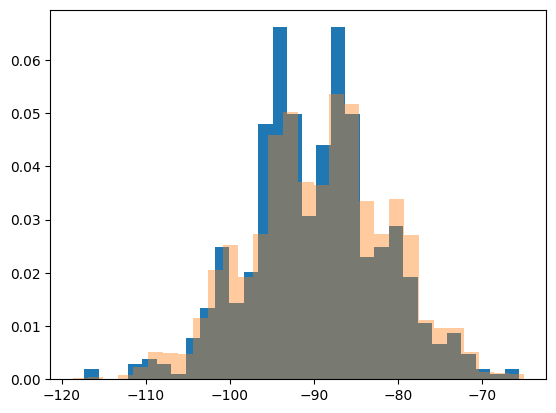

In [201]:
plt.hist(hamiltonian_rr_2b.diagonal(),bins=30,density=True)
plt.hist(hamiltonian_rr.diagonal(),bins=30,alpha=0.4,density=True)
plt.show()

In [ ]:
for i in range(hamiltonian_qr_2b.shape[0]):
    for j in range(hamiltonian_qr_2b.shape[1]):
        print('i,j',i,j)
        print(hamiltonian_qr_2b[i,j])
        print(hamiltonian_qr[i,j])
        print('\n')

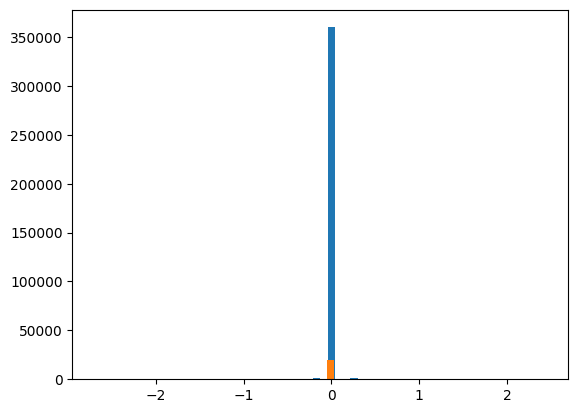

In [144]:
plt.hist(hamiltonian_qr.toarray().flatten(),bins=60)
plt.hist(hamiltonian_qr_2b.toarray().flatten(),bins=60)
plt.show()

Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [202]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2b
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr_2b @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            
            if (q_max == p_max ) and (q_min == p_min) :
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a*nparticles_b/4)

            elif (q_max==p_max) and (q_min!=p_min) and (q_max < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a/2)
            
            elif (q_max==p_max) and (q_min!=p_min) and (q_max > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_b/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_b/2)
            
            else:
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


100%|██████████| 20/20 [00:00<00:00, 27.91it/s]


#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [203]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)




We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [204]:
from tqdm import tqdm

approximations_truncated=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=((1-nparticles_a/size_a)*(1-nparticles_b/size_b))/((1-2/12)*(1-2/12))*HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*interaction_dictionary[key]
    approximations_truncated.append(operator)    

100%|██████████| 1296/1296 [00:00<00:00, 5302.91it/s]
20it [00:05,  3.93it/s]


Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [ ]:
for i in range(approximations_meanfield[0].shape[0]):
    for j in range(approximations_meanfield[0].shape[0]):
        if approximations_meanfield[0][i,j]!=0:
            print('ij=',i,j)
            print(approximations_meanfield[0][i,j])
            print(approximations_truncated[0][i,j])
            print('\n')

In [206]:
print(approximations_truncated[0])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15281 stored elements and shape (225, 225)>
  Coords	Values
  (0, 0)	67.42584294007733
  (0, 1)	2.0786867100529838
  (0, 2)	-0.9665363781487761
  (0, 3)	2.279254821062709
  (0, 4)	-1.2855557078714979
  (0, 6)	-4.141994918155913
  (0, 7)	3.2530805524395645
  (0, 10)	5.720407205518891
  (0, 11)	-1.8097149447787118
  (0, 15)	-3.424231242706855
  (0, 16)	-0.09678531717170237
  (0, 17)	0.022611208231790744
  (0, 18)	-0.02322649057496184
  (0, 19)	0.5662579318312961
  (0, 22)	-1.1154236526947232
  (0, 25)	-0.2619818929142366
  (0, 26)	0.13090102528160788
  (0, 30)	-4.668530756443733
  (0, 31)	-0.9071040432000004
  (0, 32)	1.3606560648000003
  (0, 33)	-0.08866831905920297
  (0, 34)	0.02817178672365412
  (0, 37)	-0.003024951740952386
  (0, 40)	-0.023993766433139094
  (0, 41)	0.06587543310971807
  :	:
  (224, 178)	-0.02322649057496183
  (224, 179)	2.230593132007212
  (224, 187)	-0.010010843842963517
  (224, 190)	-0.000599695360000000

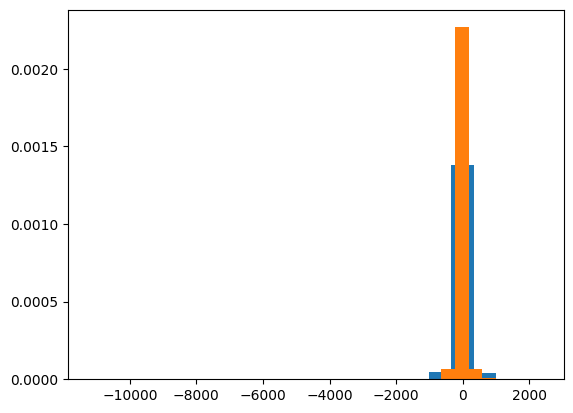

In [207]:

# we select an iteration term
idx_iteration=1
# we compare the matrix elements of each correction using an histogram
_=plt.hist(approximations[idx_iteration].toarray().flatten(),bins=20,density=True)
_=plt.hist(approximations_truncated[idx_iteration].toarray().flatten(),bins=20,density=True)


#### Now we compute the iteration using this truncation, good luck

In [208]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]

    
history_errors_truncated_brillouinwigner_method=[]
interaction_terms_truncated_brillouinwigner_method=[]
infidelities_truncated_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated[j]/e**(j+1)
    interaction_terms_truncated_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_truncated_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 300.05it/s]

-128.38215664694954
0.030179143298433835 index= 19


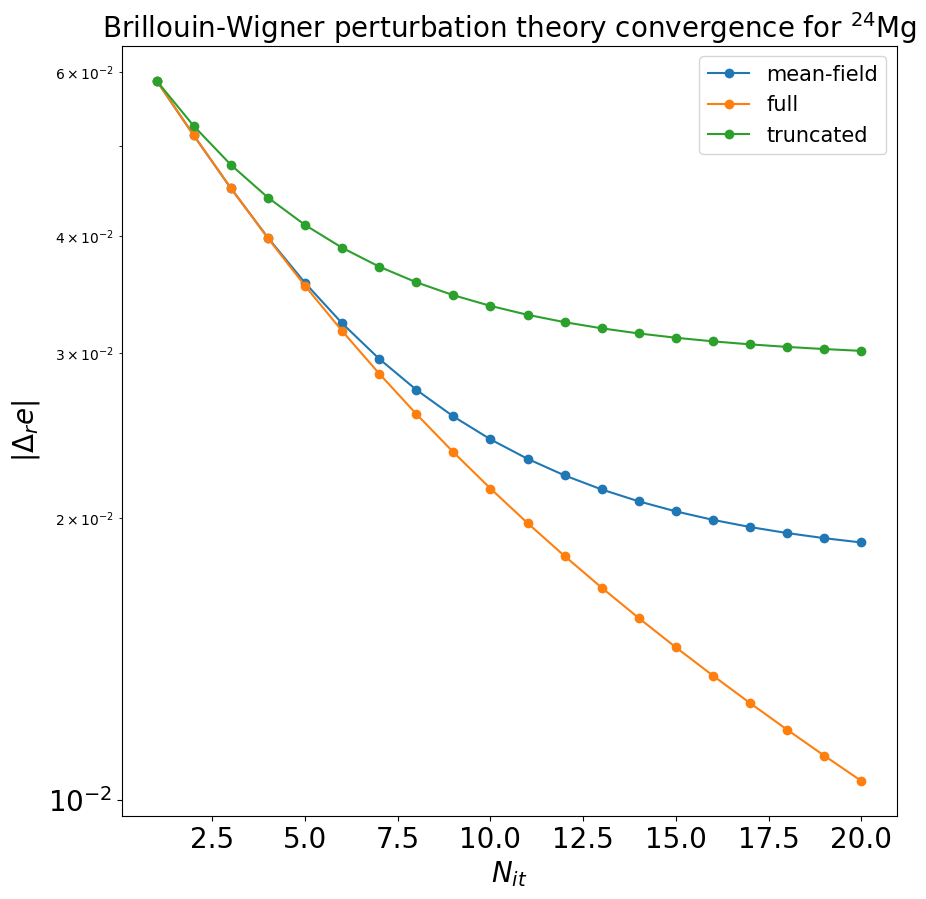

In [210]:
plt.figure(figsize=(10,10))
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
#plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_brillouinwigner_method,'-o',label='truncated')
plt.yscale('log')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$|\Delta_r e|$',fontsize=20)
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}',fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=15)
plt.show()

### Using only 2-body quasiparticle connections in $H_{QR}$ for the Brillouin-Wigner Method + uniform MF of $H_{RR}$

#### Imports

In [26]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [27]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [28]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:01<00:00, 11337.08it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

In [29]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [30]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
#hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T



#### Investigate the magnitude of $H_{QR}$

We can check that the magnitude of the couplings of the $H_{QR}$ is similar to the $H_{QR}$ of a generic many-body hamiltonian. Maybe it's important to check the connectivity to figure out if more or less we can reduce it randomly or not.

In [ ]:
for q_index in range(hamiltonian_qr_2b.shape[0]):
    for r_index in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,r_index]!=0:
            print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr_2b[q_index,r_index])
            print('\n')

#### Create the two-body corrections using the mean field uniform $H_{RR}$ with the energy scale of the full many-body Hamiltonian. 

In [32]:
from scipy.sparse import lil_matrix
hamiltonian_rr_2b=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))
# in order to take into account of the extensive magnitude of the energy
for r in range(hamiltonian_rr_2b.shape[0]):
    hamiltonian_rr_2b[r,r]=np.average(hamiltonian_rr.diagonal())#+2*gamma

Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [31]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2b
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr_2b @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            
            if (q_max == p_max ) and (q_min == p_min) :
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_a*nparticles_b/4)

            elif (q_max==p_max) and (q_min!=p_min) and (q_max < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_a/2)
            
            elif (q_max==p_max) and (q_min!=p_min) and (q_max > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_b/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_a/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_b/2)
            
            else:
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:01, 15.39it/s]


NameError: name 'hamiltonian_rr_2b' is not defined

#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [729]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)




We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [730]:
from tqdm import tqdm

approximations_truncated_uniform=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*interaction_dictionary[key]
    approximations_truncated_uniform.append(operator)    

100%|██████████| 1296/1296 [00:00<00:00, 6610.16it/s]
20it [00:04,  4.64it/s]


Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [731]:
print(approximations_truncated_uniform[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22584 stored elements and shape (300, 300)>
  Coords	Values
  (0, 0)	25.797216607359417
  (0, 1)	1.5089816396083937
  (0, 2)	3.5613356579104827
  (0, 3)	-2.0086807935492152
  (0, 4)	-2.577904416281789
  (0, 5)	-6.471867059618614
  (0, 6)	5.082938363186819
  (0, 10)	3.3814401085204895
  (0, 11)	8.938136258623267
  (0, 12)	-2.8276796012167367
  (0, 20)	-4.093847529134462
  (0, 21)	-0.14798526938191658
  (0, 22)	-0.07258278304675575
  (0, 23)	1.7695560369728005
  (0, 24)	0.41332069255555615
  (0, 26)	-3.4856989146710102
  (0, 30)	-0.8010696096873607
  (0, 31)	-0.8186934153569894
  (0, 32)	0.4090657040050246
  (0, 40)	-3.1738835942133212
  (0, 41)	-0.1305523931428572
  (0, 42)	-0.27708849706000926
  (0, 43)	0.08803683351141912
  (0, 44)	0.8848437344761901
  (0, 46)	-0.009452974190476205
  :	:
  (299, 254)	0.048767987598147815
  (299, 255)	4.252050202500001
  (299, 256)	0.03313452650000001
  (299, 257)	-0.027186583392591234
  (29

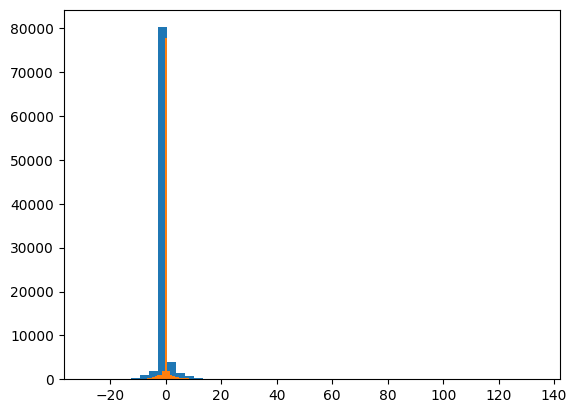

In [732]:

# we select an iteration term
idx_iteration=0
# we compare the matrix elements of each correction using an histogram
_=plt.hist(approximations[idx_iteration].toarray().flatten(),bins=50)
_=plt.hist(approximations_truncated_uniform[idx_iteration].toarray().flatten(),bins=50)

#### Now we compute the iteration using this truncation, good luck

In [733]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]

    
history_errors_truncated_uniform_meanfield_brillouinwigner_method=[]
interaction_terms_truncated_uniform_meanfield_brillouinwigner_method=[]
infidelities_truncated_uniform_meanfield_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated_uniform[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_truncated_uniform_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_uniform_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 314.63it/s]

-107.32771647714588
0.05914673846300454 index= 19


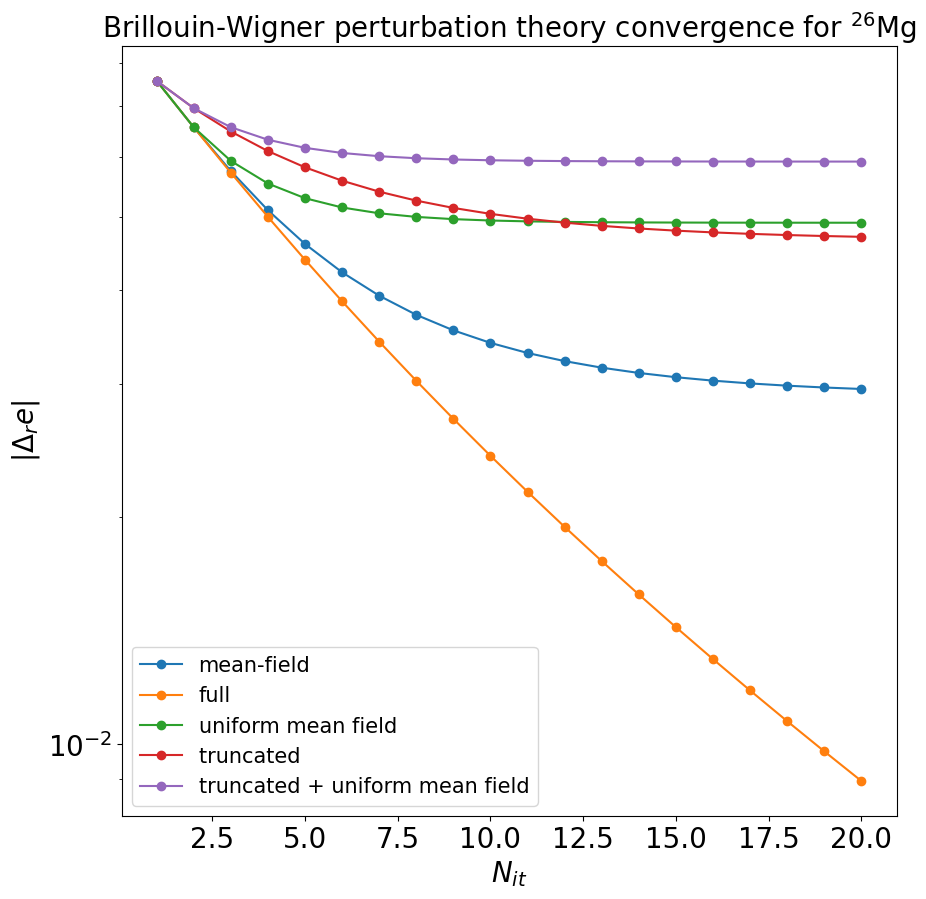

In [734]:
plt.figure(figsize=(10,10))
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_brillouinwigner_method,'-o',label='truncated ')
plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_uniform_meanfield_brillouinwigner_method,'-o',label='truncated + uniform mean field')
plt.yscale('log')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$|\Delta_r e|$',fontsize=20)
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}',fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=15)
plt.show()